In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

In [2]:
image = mpimg.imread('fig.png')
# make image smaller (faster execution) and change format from [0,1] to [0,255]
image = (image[::4,::3] * 255).astype(int)

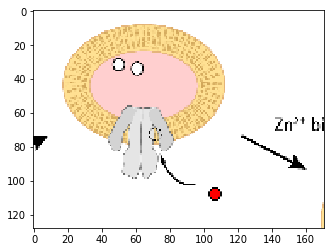

In [3]:
plt.imshow(image)
plt.show()

In [201]:
def initialize_kernels(n,k=3,c=3):
    '''
    Initialize kernels with weights and bias
        n - number of kernels/filters
        k - the size of the kernel (in pixels, square)
        c - the depth (channels)
    '''
    std = 1/np.sqrt(np.prod((n,k,k,c)))
    return np.random.normal(scale=std,size=(n,k,k,c))

def convolve(data,kernels,bias):
    '''
    Performs convolution using the given kernels and return the resulting image (summed over all kernels)
        no padding
    '''
    # get parameters
    n,k,_,ch = kernels.shape
    x,y,_ = data.shape
    # create new image array
    convolved = np.zeros([x-k+1,y-k+1,ch])
    # skip on edges (left and right)
    s_l = k//2
    s_r = k-s_l-1
    # apply convolution
    for c in range(ch):
        # for each channel (color)
        for i in range(s_l,x-s_r):
            for j in range(s_l,y-s_r):
                # sum over all kernels
                convolved[i-s_l,j-s_l,c] = (data[i-s_l:i+s_r+1,j-s_l:j+s_r+1,c] * kernels[:,:,:,c]).sum() + bias
    return convolved

def ReLU(data):
    '''Apply ReLU on the data'''
    return np.maximum(data,0)

def max_pool(data,step_size):
    '''Max pool data and reduce the number of pixels'''
    # setup parameters
    x,y,ch = data.shape
    # generate output array
    pool = np.zeros((x//step_size,y//step_size,ch))
    # reduce size
    for c in range(ch):
        # do not pool channel (color)
        for i in range(0,x-x%step_size,step_size):
            for j in range(0,y-y%step_size,step_size):
                pool[i//step_size,j//step_size,c] = np.max(data[i:i+step_size,j:j+step_size,c])
    return pool

def d_max_pool(delta, data, step_size):
    '''
    delta of the next layer (feeding backward into the max pool, weighted and after reshaping)
        original data used during the feed forward
    '''
    # output array
    x,y,ch = data.shape
    error = np.zeros(data.shape)
    # loop through x,y and color channel
    for c in range(ch):
        for i in range(0,x-x%step_size,step_size):
            for j in range(0,y-y%step_size,step_size): 
                # obtain index of largest value in input for current window
                current = data[i:i+step_size, j:j+step_size,c]
                (a, b) = np.unravel_index(np.argmax(current),current.shape)
                # update error to propagate backward (only the max value is propagated)
                error[i+a, j+b,c] = delta[i//step_size, j//step_size,c]        
                # no weights to update
    return error

In [224]:
kernels = initialize_kernels(1,6) # fix even numbers
conv = convolve(image,kernels,0)
relu = ReLU(conv)
pool = max_pool(relu,2)
dpool = d_max_pool(relu,output,2) # dummy test (pool is not the deltas)
a,b,c = d_convolve(dpool,conv,kernels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


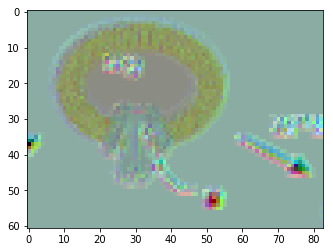

In [225]:
plt.imshow(pool.astype(int))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


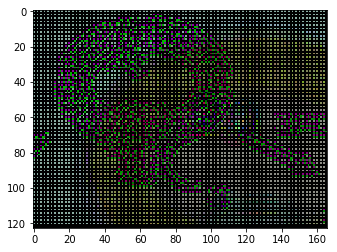

In [226]:
plt.imshow(dpool.astype(int))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


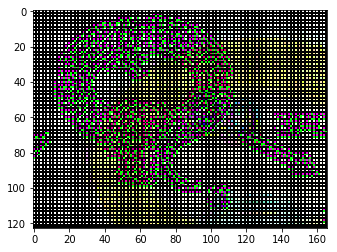

In [227]:
plt.imshow(a.astype(int))
plt.show()

In [215]:
def d_convolve(delta, data, kernels):
    '''
    delta of the next layer (back propagating into this one)
        data was the input data to this layer on the forward-propagate
    '''
    n,k,_,ch = kernels.shape
    x_,y_,_ = data.shape
    ## initialize derivatives
    error = np.zeros(data.shape) 
    d_kernels = np.zeros(kernels.shape)
    d_bias = np.zeros((n,1))
    for c in range(ch):
        for i in range(x_):
            for j in range(y_): 
                # kernel weights delta
                d_kernels[:] += delta[i,j,c] * data[i,j,c]
                # error
                for kernel in range(n):
                    error[i,j,c] += (delta[i,j,c]*kernels[kernel]).sum()             
    # loss gradient of the bias
    d_bias = np.sum(delta)
    
    return error, d_kernels, d_bias